### Experiments with Louvein algorithm for Gregorian chant repertoire tradition detection
Here we collect all exeriments with Louvein algorithm  
1. Resolution parametr search
2. Run 20 times on all data network with resolution == 1.0 and resolution == 1.1
3. Czech sources discovery run
4. Big feasts only
5. Sources united by provenance

+ separate big feasts vs all

In [2]:
# Imports
import numpy as np
import pandas as pd

import networkx as nx
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, rand_score

import matplotlib.pyplot as plt
from itertools import combinations
from random import sample, seed
from collections import Counter, OrderedDict

import lzma
import pickle

In [3]:
# Read data
responsories_all = pd.read_csv('../data/all-ci-responsories.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('../data/all-ci-antiphons.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('../data/sources-with-provenance-ids-and-two-centuries.csv', usecols=['provenance_id', 'drupal_path', 'siglum', 'cursus', 'num_century'])
feasts = pd.read_csv('../data/feast.csv', usecols=['id', 'name'])

chants = pd.concat([responsories_all, antiphons_all])

Common code

In [4]:
# Set compare metric
def jaccard_dist(a : list, b : list):
    '''
    Function returns value of Jaccard distance applied on two sets
    '''
    if len(set(a).union(set(b))) != 0:
        return (len(set(a).intersection(set(b))) / len(set(a).union(set(b))))
    else:
        return 0

In [5]:
# Source_id translate to int for smooth labels array indexing
source_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    source_dict[id] = i
    i += 1

In [7]:
def get_columns(metric, used_sources, source_chants_dict):
    ''' 
    Constructs data structures to get Graph() representing network for analysis
    '''
    len_s = len(used_sources)
    s1_column = [j for i in [len_s * [s] for s in used_sources] for j in i]
    s2_column = len_s * used_sources

    shared_column = []
    for i in range(len(s1_column)):
        s1_chants = source_chants_dict[s1_column[i]]
        s2_chants = source_chants_dict[s2_column[i]]
        shared_column.append(metric(s1_chants, s2_chants))
    
    return s1_column, s2_column, shared_column, used_sources

In [8]:
def get_graph(used_sources, source_chants_dict):
    ''' 
    Creates Graph() object from networkx lib
    '''
    s1_column, s2_column, shared_column, used_sources = get_columns(jaccard_dist, used_sources, source_chants_dict)
    nodes = used_sources
    edges = [(i, j, {'weight': round(w, 2) }) for i, j, w in zip(s1_column, s2_column, shared_column) if i != j and w != 0 and (i in used_sources and j in used_sources)]
    
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    return graph

In [9]:
def transform_to_labels(variant, used_dict):
    ''' 
    Takes communities in list of lists form and returns list of labels 
    (one for each sourcem based on indexes in used_dict)
    '''
    labels = np.zeros(len(used_dict.keys()))
    j = 0
    for community in variant:
        for vertex in community:
            labels[used_dict[vertex]] = j
        j += 1
    return labels

In [10]:
def count_jaccard(community_variants, used_dict):
    ''' 
    Counts mean of Jaccard Index between all pairs from community varinats
    '''
    jaccard = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
    for pair in all_variants_pairs:
        friends_matrix = np.zeros([len(used_dict), len(used_dict)])
        for com_ver in pair:
            for com in com_ver:
                com = sorted(list(com))
                for s_pair in combinations(com, 2):
                    friends_matrix[used_dict[s_pair[0]], used_dict[s_pair[1]]] += 1
        unique, counts = np.unique(friends_matrix.flatten(), return_counts=True)
        try:
            twos = dict(zip(unique, counts))[2]
            sig_level = twos / np.count_nonzero(friends_matrix)
        except:
            sig_level = 0.0
        jaccard.append(sig_level)
    
    return (round(np.mean(jaccard), 3)) 

In [11]:
def count_rand(community_variants_labels):
    ''' 
    Counts mean of adjusted Rand Index between all pairs from community varinats
    '''
    rand = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_variants_pairs:
        rand.append(adjusted_rand_score(pair[0], pair[1]))
    
    return (round(np.mean(rand), 3))

In [12]:
def count_mutual(community_variants_labels):
    ''' 
    Counts mean of adjusted Mutual information score between all pairs from community varinats
    '''
    mutual = []
    all_variants_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_variants_pairs:
        mutual.append(adjusted_mutual_info_score(pair[0], pair[1]))
        
    return (round(np.mean(mutual), 3))

In [38]:
# Construct needed data structures to construct networks from all data (all sources, all feasts)
drupals = sources['drupal_path'].tolist()
source_chants_dict = {}
used_sources = []

for source_id in drupals:
    chants_of_source = chants[chants['source_id'] == source_id]['cantus_id'].tolist()
    
    if chants_of_source != []:
        used_sources.append(source_id)
        try:
            source_chants_dict[source_id] += chants_of_source
        except:
            source_chants_dict[source_id] = chants_of_source

used_sources = list(set(used_sources))

### Parameter search

We have only one available parameter to be set:  
<b> resolution</b>  - default is 1  
(If resolution is less than 1, the algorithm favors larger communities, if greater than 1 favors smaller communities)


In [39]:
# Randomstates for algorithm and parametr options
random_states_res = [i for i in range(1, 151)]
resolution_opt = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]

In [40]:
all_graph = get_graph(used_sources, source_chants_dict)

In [ ]:
# Try all parametr options, for each run algorithm 50 times and count stability scores
resolution_dict = {}
num_of_runs_res = 50
for res in resolution_opt:
    print(res)
    community_variants_res = []
    community_variants_labels_res = []
    num_of_clusters_res = []
    for i in range(num_of_runs_res):
        variant = nx.community.louvain_communities(all_graph, weight='weight', resolution=res, seed=random_states_res[i])
        community_variants_res.append(variant)
        community_variants_labels_res.append(transform_to_labels(variant, source_dict))
        num_of_clusters_res.append(len(variant))
    resolution_dict[res] = (count_jaccard(community_variants_res, source_dict), count_rand(community_variants_labels_res), count_mutual(community_variants_labels_res), np.mean(num_of_clusters_res))

In [41]:
with lzma.open("saved_results/louvein/resolution_dict.txt", "rb") as model_file:
    resolution_dict = pickle.load(model_file)

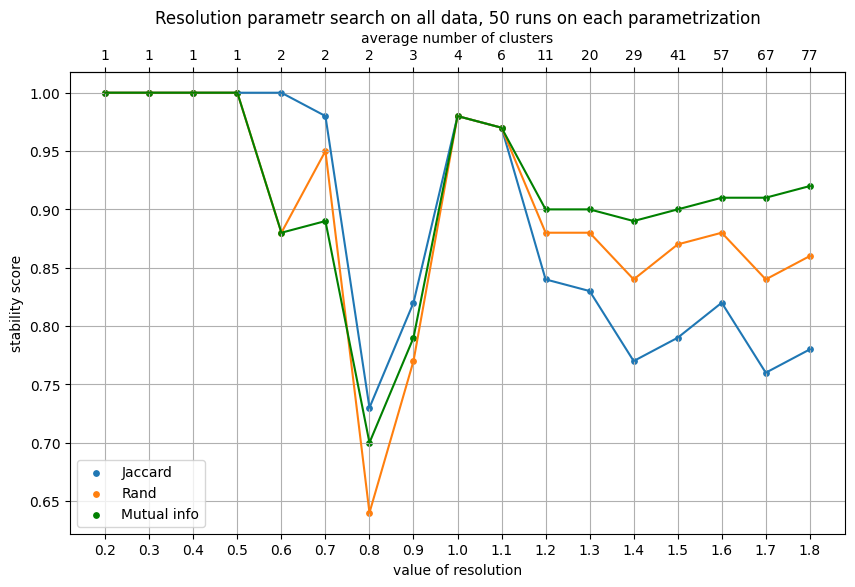

In [52]:
# Plot results of resolution parameter search
# Figure 4.3
colors = ['tab:blue', 'tab:orange', 'g']
labels = ['Jaccard', 'Rand', 'Mutual info']
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
for i in range(3):
    ax1.scatter(x=resolution_opt, y=[x[i] for x in resolution_dict.values()], marker='o', c=colors[i], s=15, label=labels[i])
    ax1.plot(resolution_opt, [x[i] for x in resolution_dict.values()], c=colors[i])

ax2 = ax1.secondary_xaxis('top')
avg_clusters = [round(x[3]) for x in resolution_dict.values()]
ax2.set_xlabel("average number of clusters")
ax2.set_xticks(resolution_opt)
ax2.set_xticklabels(avg_clusters)

plt.title("Resolution parametr search on all data, 50 runs on each parametrization")
plt.xticks(resolution_opt)
plt.xlabel("value of resolution")
plt.ylabel("stability score")
plt.legend(loc='lower left')
plt.grid()
plt.show()

Not mentioned in thesis section

In [46]:
#Resolution and seed generating stable four communities
random_states_r = [i for i in range(1, 51)]
community_variants_res = []
community_variants_labels_res = []
num_of_clusters_res = []
for i in range(50):
    variant = nx.community.louvain_communities(all_graph, weight='weight', resolution=1.0, seed=random_states_r[i])
    community_variants_res.append(variant)
    community_variants_labels_res.append(transform_to_labels(variant, source_dict))
    num_of_clusters_res.append(len(variant))

In [44]:
print((count_jaccard(community_variants_res, source_dict), count_rand(community_variants_labels_res), count_mutual(community_variants_labels_res), np.mean(num_of_clusters_res)))

(1.0, 1.0, 1.0, 4.0)


In [47]:
for com in community_variants_res[0]:
    #print(len(com), com)
    print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))

93 [' E-Bbc M 662', 'A-Gu 30', 'A-KN 1012', 'A-KN 1018', 'A-KN 589', 'A-Wda C-10', 'A-Wda D-4', 'Antifonario Antifonario de la Santa Cruz de Serós', 'B-Gu Hs BKT.006', 'CDN-Mlr MS Medieval 0073', 'CDN-Mlr MS Medieval 0234', 'CH-SGs 391', 'CZ-Bu R 387', 'CZ-Pn XII A 21', 'CZ-Pu VI E 13', 'CZ-Pu VI G 3a', 'CZ-Pu XII C 3', 'CZ-Pu XII E 15b', 'CZ-Pu XII E 15c', 'CZ-Pu XIII C 1a', 'CZ-Pu XIII C 4', 'CZ-Pu XIV C 20', 'CZ-Pu XIV G 46', 'CZ-Pu XXIII D 156 ', 'CZ-R R 17', 'D-BAs Msc.Lit.25', 'D-FUl Aa 55', 'D-MZb C', 'D-MZb D', 'D-MZb E', 'D-Mbs Clm 4304', 'D-Mbs Clm 4305', 'D-Mbs Clm 4306', 'D-W 28 Helmst.', 'DK-Kk 3449 8o [03] III', 'DK-Kk 3449 8o [06] VI', 'DK-Kk 3449 8o [07] VII', 'DK-Kk 3449 8o [08] VIII', 'DK-Kk 3449 8o [09] IX', 'DK-Kk 3449 8o [10] X', 'DK-Kk 3449 8o [11] XI', 'DK-Kk 3449 8o [12] XII', 'DK-Kk 3449 8o [13] XIII', 'DK-Kk 3449 8o [14] XIV', 'DK-Kk 3449 8o [16] XVI', 'DK-Kk 3449 8o [17] XVII', 'E-Bbc M 1327', 'E-Bbc M 3701', 'E-E E-E, L. III. 3.', 'E-E E-E, L. III. 4.', 'E-H

### All data network

Construct network from all available data with resolution == 1.0 and resolution == 1.1 and count score of results

In [48]:
# Settings
num_of_runs_all = 50
random_states_all = [x for x in range(1, 1001)]
all_res = [1.0, 1.1]

In [13]:
# Make 5 x 50 runs for each resolution on all data
community_variants_all = []
community_variants_labels_all = []
num_of_clusters_all = []
for r in range(len(all_res)): 
    rndm_idx = 0
    community_variants_all.append([])
    community_variants_labels_all.append([])
    num_of_clusters_all.append([])
    for j in range(5):
        community_variants_all[r].append([])
        community_variants_labels_all[r].append([])
        num_of_clusters_all[r].append([])
        all_graph = get_graph(used_sources, source_chants_dict)
        for i in range(num_of_runs_all):
            variant = nx.community.louvain_communities(all_graph, weight='weight', resolution=all_res[r], seed=random_states_all[rndm_idx])
            community_variants_all[r][j].append(variant)
            num_of_clusters_all[r][j].append(len(variant))
            community_variants_labels_all[r][j].append(transform_to_labels(variant, source_dict))
            rndm_idx+=1
    
    print('Resolution:', all_res[r])
    print('Results of', num_of_runs_all, 'runs on all data network')
    print('Average number of clusters:', [np.mean(num_of_clusters_all[r][x]) for x in range(5)])
    print('Jaccard score:', [count_jaccard(community_variants_all[r][x], source_dict) for x in range(5)])
    print('Rand score:', [count_rand(community_variants_labels_all[r][x]) for x in range(5)])
    print('Mutual info score:', [count_mutual(community_variants_labels_all[r][x]) for x in range(5)])
    print()

Resolution: 1.0
Results of 50 runs on all data network
Average number of clusters: [4.0, 4.0, 4.0, 3.98, 4.0]
Jaccard score: [0.977, 0.987, 0.988, 0.982, 0.978]
Rand score: [0.981, 0.989, 0.99, 0.983, 0.982]
Mutual info score: [0.984, 0.99, 0.991, 0.987, 0.984]

Resolution: 1.1
Results of 50 runs on all data network
Average number of clusters: [6.18, 6.08, 6.32, 6.26, 6.2]
Jaccard score: [0.983, 0.972, 0.986, 0.979, 0.976]
Rand score: [0.988, 0.98, 0.99, 0.985, 0.983]
Mutual info score: [0.983, 0.972, 0.985, 0.977, 0.976]



In [ ]:
all_dict = {'cluster' : num_of_clusters_all, 'var' : community_variants_all, 'var_labels' : community_variants_labels_all}

In [49]:
#with lzma.open("saved_results/louvein/all_dict.txt", "rb") as model_file:
#    all_dict = pickle.load(model_file)

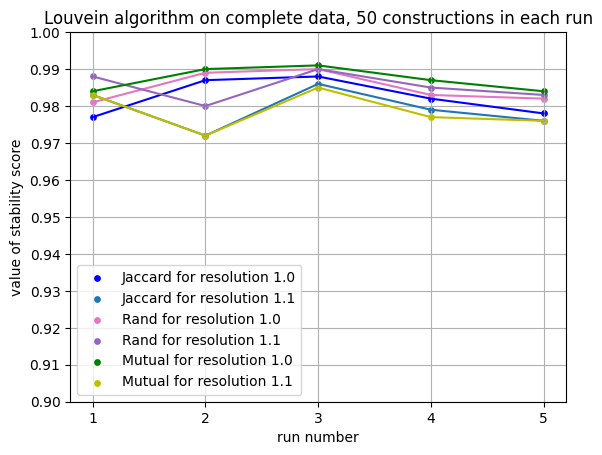

In [50]:
# Display results on all data for both tested resolutions
# All in one plot
colors = ['b', 'tab:orange', 'tab:pink', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'r', 'tab:gray', 'y', 'm']
metrics = ['Jaccard', 'Rand', 'Mutual']
fig = plt.figure()
ax1 = fig.add_subplot(111)

j = 0
for i in range(len(all_res)):
    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(all_dict['var'][i][x], source_dict) for x in range(5)], s=15, c=colors[j], marker="o", label="Jaccard for resolution "+str(all_res[i]))
    ax1.plot([1, 2, 3, 4, 5], [count_jaccard(all_dict['var'][i][x], source_dict) for x in range(5)], c=colors[j])
    j+=3

j = 2
for i in range(len(all_res)):
    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(all_dict['var_labels'][i][x]) for x in range(5)], s=15, c=colors[j], marker="o", label="Rand for resolution "+str(all_res[i]))
    ax1.plot([1, 2, 3, 4, 5], [count_rand(all_dict['var_labels'][i][x]) for x in range(5)], c=colors[j])
    j+=3

j = 4
for i in range(len(all_res)):
    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(all_dict['var_labels'][i][x]) for x in range(5)], s=15, c=colors[j], marker="o", label="Mutual for resolution "+str(all_res[i]))
    ax1.plot([1, 2, 3, 4, 5], [count_mutual(all_dict['var_labels'][i][x]) for x in range(5)], c=colors[j])
    j+=6

plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("stability score")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.title("Louvein algorithm on complete data, 50 constructions in each run")
plt.grid()
plt.legend(loc='lower left')
plt.show()

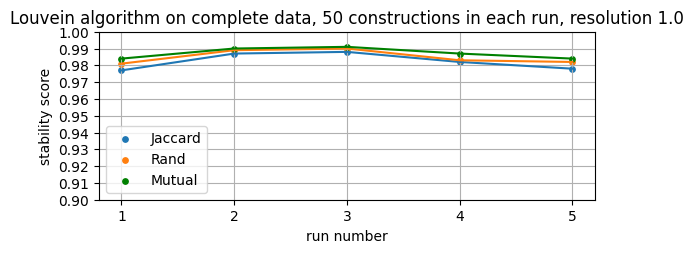

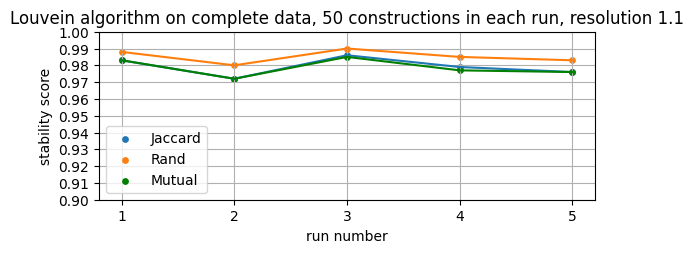

In [54]:
# Display results on all data for both tested resolutions
# Separate plot for each resolution
# Figure 4.4
plt.subplot(2, 1, 1)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(all_dict['var'][0][x], source_dict) for x in range(5)], s=15, c='tab:blue', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(all_dict['var'][0][x], source_dict) for x in range(5)], c='tab:blue')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(all_dict['var_labels'][0][x]) for x in range(5)], s=15, c='tab:orange', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(all_dict['var_labels'][0][x]) for x in range(5)], c='tab:orange')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(all_dict['var_labels'][0][x]) for x in range(5)], s=15, c='g', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(all_dict['var_labels'][0][x]) for x in range(5)], c='g')

plt.title('Louvein algorithm on complete data, 50 constructions in each run, resolution 1.0')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("stability score")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()


plt.subplot(2, 1, 2)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(all_dict['var'][1][x], source_dict) for x in range(5)], s=15, c='tab:blue', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(all_dict['var'][1][x], source_dict) for x in range(5)], c='tab:blue')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(all_dict['var_labels'][1][x]) for x in range(5)], s=15, c='tab:orange', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(all_dict['var_labels'][1][x]) for x in range(5)], c='tab:orange')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(all_dict['var_labels'][1][x]) for x in range(5)], s=15, c='g', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(all_dict['var_labels'][1][x]) for x in range(5)], c='g')

plt.title('Louvein algorithm on complete data, 50 constructions in each run, resolution 1.1')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("stability score")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()

### Czech sources behaviour
Construct network only from data for feasts that are in all "our" six sources and obsreve on what resolution they separate and how

In [55]:
six_czech_sources = {"http://cantusbohemiae.cz/source/33177" : "CZ-Pn XII A 24", 
                      "http://cantusbohemiae.cz/source/4478" : "CZ-Pu Pu XIV A 19", 
                      "http://cantusbohemiae.cz/source/28509" : "CZ-Pn XV A 10",
                      "http://cantusdatabase.org/source/123730" : "CZ-Pu XIV B 13", 
                      "http://cantusdatabase.org/source/123727" : "CZ-Pu VI.E.4c", 
                      "http://cantusbohemiae.cz/source/28488" : "CZ-Pu VI G 11"}

In [56]:
cathedral_used_feats = []
for sI in list(six_czech_sources.keys())[:3]:
    print(sI, 'number of records:', len(chants[chants['source_id'] == sI]))
    cathedral_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

# Cathedral field
freqC = Counter(cathedral_used_feats)
three_cathedral_feasts = []
for key in freqC.keys():
    if freqC[key] >=3:
        three_cathedral_feasts.append(key)

# George monastery
monastery_used_feats = []
for sI in list(six_czech_sources.keys())[3:]:
    print(sI, len(chants[chants['source_id'] == sI]))
    monastery_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

freqM = Counter(monastery_used_feats)
three_monastery_feasts = []
for key in freqM.keys():
    if freqM[key] >= 3:
        three_monastery_feasts.append(key)

complete_feasts = set(three_cathedral_feasts).intersection(set(three_monastery_feasts))
print("Number of feast in all six sources:", len(complete_feasts))

http://cantusbohemiae.cz/source/33177 number of records: 582
http://cantusbohemiae.cz/source/4478 number of records: 988
http://cantusbohemiae.cz/source/28509 number of records: 1741
http://cantusdatabase.org/source/123730 1403
http://cantusdatabase.org/source/123727 2327
http://cantusbohemiae.cz/source/28488 2616
Number of feast in all six sources: 37


In [27]:
# Complete needed data into data structures for Graph() construction
feast_source_chants_dict = {}
feast_used_cantus_ids = []
feast_used_sources = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants[chants['source_id'] == source_id]
    source_feast_chants = (filt_source[filt_source['feast_id'].isin(complete_feasts)]['cantus_id']).tolist()
    if source_feast_chants != []:
        feast_used_cantus_ids += source_feast_chants 
        feast_source_chants_dict[source_id] = source_feast_chants
        feast_used_sources.append(source_id)

print("Used sources:", len(feast_used_sources))
print('Number of CIDs used in our sources:', len(set(feast_used_cantus_ids)))

Used sources: 153
Number of CIDs used in our sources: 1224


In [16]:
# Settings
resolution_opt = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]

In [42]:
# Run one construction for each resolution, one random seed for all resolution options
czech_dict = {}
num_of_clusters_feast = []
czech_graph = get_graph(feast_used_sources, feast_source_chants_dict)
for res in resolution_opt:
    community_variants_feast = []
    community_variants_labels_feast = []
    variant = nx.community.louvain_communities(czech_graph, weight='weight', resolution=res, seed=42)
    num_of_clusters_feast.append(len(variant))
    czech_dict[res] = variant

In [32]:
# Display results
for res in resolution_opt:
    print(res, ':')
    for com in czech_dict[res]:
        print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))
    print()

0.2 :
150 [' E-Bbc M 662', ' rps 12720 V', '1', 'A-Gu 29', 'A-KN 1010', 'A-KN 1011', 'A-KN 1013', 'A-KN 1015', 'A-KN 1017', 'A-KR VI/258', 'A-LIs 290', 'A-SF XI 480', 'A-VOR 287', 'A-Wda C-11', 'A-Wda D-4', 'A-Wn 1799**', 'A-Wn 1890', 'AUS-Sfl Add. Ms. 413', 'B-Br Ms IV/473', 'B-TO olv 63', 'B-TO olv 64', 'CDN-Hsmu M2149.L4', 'CDN-Mlr MS Medieval 0073', 'CDN-Mlr MS Medieval 0234', 'CH-E 611', 'CH-Fco Ms. 2', 'CH-SGs 388', 'CH-SGs 390', 'CZ-Pn XV A 10', 'CZ-Pst DE I 7', 'CZ-Pu Pu XIV A 19', 'CZ-Pu VI G 11', 'CZ-Pu VI.E.4c', 'CZ-Pu XIV B 13', 'Cz-Pn XII A 24', 'D-AAm G 20', 'D-B Mus. 40047', 'D-BAs Msc.Lit.25', 'D-KA Aug. LX', 'D-KNd 1161', 'D-KNd 215', 'D-MZb A', 'D-Ma 12o Cmm 1', 'D-Mbs Clm 4303', 'D-Mbs Clm 4306', 'D-Sl HB.I.55', 'D-W 29 Helmst.', 'DK-Kk 3449 8o [01] I', 'DK-Kk 3449 8o [02] II', 'DK-Kk 3449 8o [04] IV', 'E-BAR Cj. 95', 'E-BAR, s.s.', 'E-Bbc E-Bbc, M 705', 'E-Bbc E-Bbc, Ms. 619', 'E-Bbc M 663', 'E-Bbc M 706', 'E-Bbc Ms. 2545', 'E-Gs ms. 45 (olim Sant Feliu, 20)', 'E-H 

##### Some possible interesting details on Czech sources
- first 5 all same and very inbalanced
- 1.1 seems (again) like ideal resolution parameter -> separates czech sources in meaningful way but also does not generate too many communities

In [33]:
print(count_jaccard(list(czech_dict.values())[:5], source_dict))
for com in czech_dict[0.2]:
    print(len(com), com)

1.0
150 {'http://musicahispanica.eu/source/20228', 'http://cantusdatabase.org/source/123689', 'https://pemdatabase.eu/source/105632', 'http://cantusdatabase.org/source/123669', 'http://cantus.ispan.pl/source/14397', 'http://cantus.ispan.pl/source/21623', 'http://cantusdatabase.org/source/123604', 'http://cantusdatabase.org/source/123595', 'http://cantusdatabase.org/source/649450', 'https://pemdatabase.eu/source/62867', 'http://cantusdatabase.org/source/123671', 'http://musicahispanica.eu/source/20229', 'http://cantusdatabase.org/source/123655', 'http://cantusdatabase.org/source/123741', 'http://cantusdatabase.org/source/123634', 'http://cantusdatabase.org/source/123756', 'http://cantusdatabase.org/source/123715', 'http://cantusdatabase.org/source/123664', 'http://cantusdatabase.org/source/620437', 'http://cantusdatabase.org/source/123661', 'http://cantusdatabase.org/source/123603', 'http://cantusdatabase.org/source/123639', 'http://cantusdatabase.org/source/123717', 'http://cantusdatab

In [34]:
for com in  czech_dict[1.0]:
    print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))

65 ['A-KR VI/258', 'A-Wda C-11', 'A-Wda D-4', 'AUS-Sfl Add. Ms. 413', 'B-TO olv 63', 'B-TO olv 64', 'CH-Fco Ms. 2', 'Cz-Pn XII A 24', 'D-BAs Msc.Lit.25', 'D-MZb A', 'D-Ma 12o Cmm 1', 'D-Mbs Clm 4303', 'D-Mbs Clm 4306', 'DK-Kk 3449 8o [01] I', 'E-BAR, s.s.', 'E-Bbc E-Bbc, M 705', 'E-Bbc E-Bbc, Ms. 619', 'E-Bbc M 663', 'E-Bbc Ms. 2545', 'E-Gs ms. 45 (olim Sant Feliu, 20)', 'E-H Ms. 2', 'E-H, Ms. 7 (ant. 5)', 'E-SI ms. 9', 'E-Tc 44.2', 'F-AS 465 (CGM 893)', 'F-CA 38', 'F-CA Impr. XVI C 4', 'F-Col_part Mont-Renaud', 'F-Pn Lat. 1085', 'F-Pn Lat. 1090', 'F-Pn Lat. 1240', 'F-Pn Lat. 12584', 'F-Pn Lat. 15181', 'F-Pn Lat. 17296', 'F-Pn Lat. 17436', 'F-Pn Lat. 17991', 'F-Pn NAL 01236', 'F-Pn NAL 1535', 'F-TOm 149', 'F-VAL 114', 'GB-Lbl Add MS 30848', 'GB-WO F.160', 'GB-WO F.160 (Facs)', 'H-Bu lat. 118', 'HR-Hf Cod. C', 'I-Ac 694', 'I-Ad 5', 'I-BV V 19', 'I-CHV', 'I-Far', 'I-Fl Conv. sopp. 560', 'I-Lc 601', 'I-MZ 15/79', 'I-Nn vi.E.20', 'I-PCd cod. 65', 'I-VCd CLXX', 'Mar. F 408', 'P-BRs Ms. 032'

In [35]:
for com in  czech_dict[1.1]:
    print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))

6 ['CH-SGs 388', 'CH-SGs 390', 'D-B Mus. 40047', 'D-KNd 215', 'GB-Ob MS. Laud Misc. 284', 'NL-Uu 406 (3 J 7)']
10 ['CH-Fco Ms. 2', 'D-Ma 12o Cmm 1', 'D-Mbs Clm 4303', 'H-Bu lat. 118', 'I-Ac 693', 'I-Ac 694', 'I-Ad 5', 'I-Nn vi.E.20', 'I-PCd cod. 65', 'US-Cn 24']
3 ['GB-WO F.160', 'GB-WO F.160 (Facs)', 'I-VCd CLXX']
2 ['A-Wda C-11', 'I-CHV']
9 ['A-Gu 29', 'A-LIs 290', 'A-Wn 1890', 'CH-E 611', 'CZ-Pu VI G 11', 'CZ-Pu VI.E.4c', 'CZ-Pu XIV B 13', 'D-KA Aug. LX', 'D-Sl HB.I.55']
7 ['F-AI 44', 'F-Col_part Mont-Renaud', 'F-Pn Lat. 1085', 'F-Pn Lat. 17296', 'GB-Lbl Add MS 30848', 'GB-Lbl Add MS 30850', 'I-Far']
6 ['A-KN 1011', 'A-KN 1013', 'A-KN 1015', 'A-SF XI 480', 'D-AAm G 20', 'SI-Lna 18 (olim 17)']
8 [' rps 12720 V', 'A-Wn 1799**', 'CDN-Hsmu M2149.L4', 'D-KNd 1161', 'F-Pn NAL 1411', 'P-AR Res. Ms. 021', 'PL-WRu I F 401', 'Theol. Lat. Qu. 149']
22 ['A-KR VI/258', 'A-Wda D-4', 'AUS-Sfl Add. Ms. 413', 'D-BAs Msc.Lit.25', 'D-Mbs Clm 4306', 'DK-Kk 3449 8o [01] I', 'E-BAR, s.s.', 'E-Bbc E-Bbc, 

#### Only more similar sources

In [30]:
# Complete needed data - this time only sources with at least 30 out of 37 shared feasts
whole_feast_source_chants_dict = {}
whole_feast_used_cantus_ids = []
whole_feast_used_sources = []

thirty_sources = []
for source_id in sources['drupal_path'].tolist():
    if len(set(complete_feasts).intersection(set(chants[chants['source_id'] == source_id]['feast_id'].tolist()))) >= 30:
        thirty_sources.append(source_id)

for source_id in thirty_sources:
    filt_source = chants[chants['source_id'] == source_id]
    whole_source_feast_chants = (filt_source[filt_source['feast_id'].isin(complete_feasts)]['cantus_id']).tolist()
    if whole_source_feast_chants != []:
        whole_feast_used_cantus_ids += whole_source_feast_chants 
        whole_feast_source_chants_dict[source_id] = whole_source_feast_chants
        whole_feast_used_sources.append(source_id)

print("Used sources:", len(whole_feast_used_sources))
print('Number of CIDs used in our sources:', len(set(whole_feast_used_cantus_ids)))

Used sources: 81
Number of CIDs used in our sources: 1071


In [ ]:
# Run on all resolution options one community search
whole_czech_dict = {}
num_of_clusters_whole_feast = []
whole_czech_graph = get_graph(whole_feast_used_sources, whole_feast_source_chants_dict)
for res in resolution_opt:
    print(res)
    community_variants_feast = []
    community_variants_labels_feast = []
    variant = nx.community.louvain_communities(whole_czech_graph, weight='weight', resolution=res, seed=42)
    num_of_clusters_whole_feast.append(len(variant))
    whole_czech_dict[res] = variant

In [37]:
for res in resolution_opt:
    print(res, ':')
    for com in whole_czech_dict[res]:
        print(len(com), sorted([sources[sources['drupal_path'] == s]['siglum'].tolist()[0] for s in com]))
    print()

0.2 :
81 [' rps 12720 V', 'A-Gu 29', 'A-KN 1011', 'A-KN 1013', 'A-KN 1015', 'A-LIs 290', 'A-Wda C-11', 'A-Wn 1799**', 'A-Wn 1890', 'AUS-Sfl Add. Ms. 413', 'B-TO olv 63', 'B-TO olv 64', 'CDN-Hsmu M2149.L4', 'CH-E 611', 'CH-Fco Ms. 2', 'CH-SGs 388', 'CH-SGs 390', 'CZ-Pn XV A 10', 'CZ-Pu Pu XIV A 19', 'CZ-Pu VI G 11', 'CZ-Pu VI.E.4c', 'CZ-Pu XIV B 13', 'Cz-Pn XII A 24', 'D-AAm G 20', 'D-B Mus. 40047', 'D-KA Aug. LX', 'D-KNd 1161', 'D-KNd 215', 'D-MZb A', 'D-Ma 12o Cmm 1', 'D-Mbs Clm 4303', 'D-Mbs Clm 4306', 'D-Sl HB.I.55', 'D-W 29 Helmst.', 'E-Bbc E-Bbc, M 705', 'E-Bbc E-Bbc, Ms. 619', 'E-Gs ms. 45 (olim Sant Feliu, 20)', 'E-H Ms. 2', 'E-H, Ms. 7 (ant. 5)', 'F-AS 465 (CGM 893)', 'F-CA 38', 'F-CA Impr. XVI C 4', 'F-Pn Lat. 1085', 'F-Pn Lat. 1090', 'F-Pn Lat. 1240', 'F-Pn Lat. 15181', 'F-Pn Lat. 17296', 'F-Pn NAL 01236', 'F-Pn NAL 1411', 'F-Pn NAL 1535', 'F-TOm 149', 'F-VAL 114', 'GB-Lbl Add MS 30850', 'GB-Ob MS. Canon. Liturg. 202', 'GB-Ob MS. Laud Misc. 284', 'GB-WO F.160', 'GB-WO F.160 (

### Big feasts network

In [57]:
# Get 10 feasts with most data
biggest_feasts = chants['feast_id'].value_counts()[:10].keys()

for feast_id in biggest_feasts.tolist():
    print(feasts[feasts['id'] == feast_id]['name'].values[0])

Nativitas Domini
Purificatio Mariae
Epiphania
Assumptio Mariae
Comm. Apostolorum
Comm. plurimorum Martyrum
Omnium Sanctorum
Fer. 5 in Cena Dom.
Dom. in Palmis
Joannis Baptistae


In [58]:
all_big_f_sources = []
for source_id in sources['drupal_path'].tolist():
    if len(set(biggest_feasts.tolist()).intersection(set(chants[chants['source_id'] == source_id]['feast_id'].tolist()))) == 10:
        all_big_f_sources.append(source_id)

print('Number of sources containing all our biggest feasts:', len(all_big_f_sources))

Number of sources containing all our biggest feasts: 51


In [59]:
# Construct documents structure for those feasts and sources
source_chants_dict_big_f = {}
used_cantus_ids_f = []
for source_id in all_big_f_sources:
    filt_source = chants['source_id'] == source_id
    source_chants = chants[filt_source]
    if (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist() != []:
        used_cantus_ids_f += (source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id']).tolist()
        source_chants_dict_big_f[source_id] = source_chants[source_chants['feast_id'].isin(biggest_feasts.tolist())]['cantus_id'].tolist()

print('Number of cantus_ids used in our sources:', len(set(used_cantus_ids_f)))
print('Number of sources containing all our biggest feasts:', len(source_chants_dict_big_f))

Number of cantus_ids used in our sources: 1293
Number of sources containing all our biggest feasts: 51


In [60]:
# dictionary for that 51 sources indexing (for Jaccard Index)
big_feast_dict = OrderedDict()
i = 0
for id in source_chants_dict_big_f.keys():
    big_feast_dict[id] = i
    i += 1

In [61]:
# Settings
res_big_f = [1.0, 1.1]
num_of_runs_big_f = 50
random_states_big_f = [x for x in range(1, 1001)]

In [62]:
big_f_graph = get_graph(list(source_chants_dict_big_f.keys()), source_chants_dict_big_f)
community_variants_big_f = []
community_variants_labels_big_f = []
num_of_clusters_big_f = []
for r in range(len(res_big_f)): 
    rndm_idx = 0
    community_variants_big_f.append([])
    community_variants_labels_big_f.append([])
    num_of_clusters_big_f.append([])
    for j in range(5):
        community_variants_big_f[r].append([])
        community_variants_labels_big_f[r].append([])
        num_of_clusters_big_f[r].append([])
        for i in range(num_of_runs_big_f):
            variant = nx.community.louvain_communities(big_f_graph, weight='weight', resolution=res_big_f[r], seed=random_states_big_f[rndm_idx])
            community_variants_big_f[r][j].append(variant)
            num_of_clusters_big_f[r][j].append(len(variant))
            community_variants_labels_big_f[r][j].append(transform_to_labels(variant, big_feast_dict))
            rndm_idx+=1
    
    print('Resolution:', res_big_f[r])
    print('Results of', num_of_runs_big_f, 'runs on all data network')
    print('Average number of clusters:', [np.mean(num_of_clusters_big_f[r][x]) for x in range(5)])
    print('Jaccard score:', [count_jaccard(community_variants_big_f[r][x], big_feast_dict) for x in range(5)])
    print('Rand score:', [count_rand(community_variants_labels_big_f[r][x]) for x in range(5)])
    print('Mutual info score:', [count_mutual(community_variants_labels_big_f[r][x]) for x in range(5)])
    print()

Resolution: 1.0
Results of 50 runs on all data network
Average number of clusters: [3.0, 3.0, 3.0, 3.0, 3.0]
Jaccard score: [0.842, 0.916, 0.824, 0.9, 0.843]
Rand score: [0.843, 0.921, 0.827, 0.904, 0.849]
Mutual info score: [0.855, 0.926, 0.837, 0.911, 0.859]

Resolution: 1.1
Results of 50 runs on all data network
Average number of clusters: [9.24, 9.32, 9.26, 9.3, 9.2]
Jaccard score: [0.948, 0.95, 0.964, 0.961, 0.974]
Rand score: [0.968, 0.97, 0.978, 0.977, 0.984]
Mutual info score: [0.963, 0.964, 0.974, 0.972, 0.981]



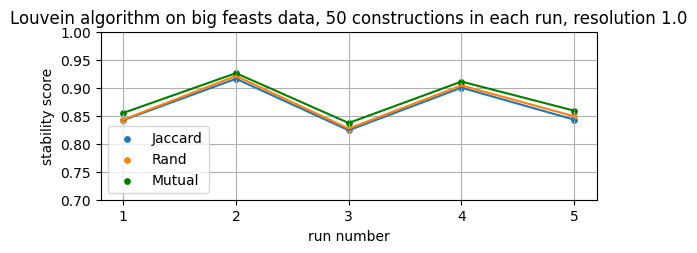

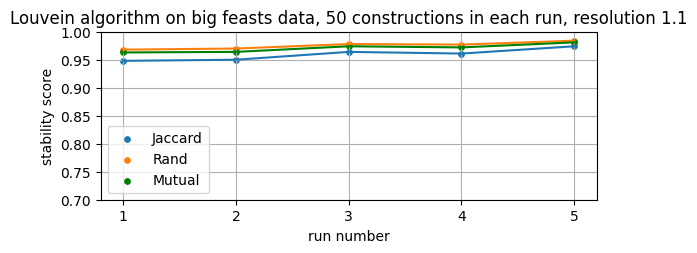

In [71]:
# Display results on 10 biggest feasts data for both tested resolutions
# Separate plot for each resolution
# Figure 4.5
plt.subplot(2, 1, 1)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(community_variants_big_f[0][x], big_feast_dict) for x in range(5)], s=15, c='tab:blue', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(community_variants_big_f[0][x], big_feast_dict) for x in range(5)], c='tab:blue')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(community_variants_labels_big_f[0][x]) for x in range(5)], s=15, c='tab:orange', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(community_variants_labels_big_f[0][x]) for x in range(5)], c='tab:orange')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(community_variants_labels_big_f[0][x]) for x in range(5)], s=15, c='g', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(community_variants_labels_big_f[0][x]) for x in range(5)], c='g')

plt.title('Louvein algorithm on big feasts data, 50 constructions in each run, resolution 1.0')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("stability score")
plt.yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()


plt.subplot(2, 1, 2)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(community_variants_big_f[1][x], big_feast_dict) for x in range(5)], s=15, c='tab:blue', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(community_variants_big_f[1][x], big_feast_dict) for x in range(5)], c='tab:blue')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(community_variants_labels_big_f[1][x]) for x in range(5)], s=15, c='tab:orange', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(community_variants_labels_big_f[1][x]) for x in range(5)], c='tab:orange')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(community_variants_labels_big_f[1][x]) for x in range(5)], s=15, c='g', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(community_variants_labels_big_f[1][x]) for x in range(5)], c='g')

plt.title('Louvein algorithm on big feasts data, 50 constructions in each run, resolution 1.1')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("stability score")
plt.yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()

### Provenance union
Here we try to merge content of books from same century, place and with same cursus (otherwise we left sources as they were)

In [65]:
# Provenance union - consider also century and cursus
sources['provenance_id'] = sources['provenance_id'].fillna('unknown')
prov_source_dict = {}
prov_chant_dict = {}
i=0
for index, row in sources.iterrows():
        # new place bc of unknown some info
    if row['cursus'] == 'Unknown' or row['num_century'] == 'unknown' or row['provenance_id'] == 'unknown':
        prov_source_dict[row['provenance_id']+'_'+str(i)] = [row['drupal_path']]
        i+=1
    # we have such place without unknown positions
    elif row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus'] in prov_source_dict.keys():
        prov_source_dict[row['provenance_id']+'_'+str(row['num_century'])+'_'+row['cursus']].append(row['drupal_path'])
    # new time-cursus-place without unknown positions
    else: 
        prov_source_dict[row['provenance_id']+'_'+row['num_century']+'_'+row['cursus']] = [row['drupal_path']]

for prov in prov_source_dict.keys():
    prov_chant_dict[prov] = []
    for source_id in prov_source_dict[prov]:
        filt_source = chants['source_id'] == source_id
        prov_chant_dict[prov] += (chants[filt_source]['cantus_id']).tolist()

print('number of reduced source points:',  len(prov_chant_dict), '(out of', len(sources), 'sources)')

number of reduced source points: 193 (out of 250 sources)


In [66]:
# Dictionary for new sources indexing (used in Jaccard Index computation)
used_provenances = list(prov_chant_dict.keys())
provenance_dict = OrderedDict()
i = 0
for id in used_provenances:
    provenance_dict[id] = i
    i += 1

In [67]:
# Settings
res_prov = [1.0, 1.1]
num_of_runs_prov = 50
random_states_prov = [x for x in range(1, 1001)]

In [68]:
prov_graph = get_graph(list(prov_chant_dict.keys()), prov_chant_dict)
community_variants_prov = []
community_variants_labels_prov = []
num_of_clusters_prov = []
for r in range(len(res_prov)): 
    rndm_idx = 0
    community_variants_prov.append([])
    community_variants_labels_prov.append([])
    num_of_clusters_prov.append([])
    for j in range(5):
        community_variants_prov[r].append([])
        community_variants_labels_prov[r].append([])
        num_of_clusters_prov[r].append([])
        for i in range(num_of_runs_prov):
            variant = nx.community.louvain_communities(prov_graph, weight='weight', resolution=res_prov[r], seed=random_states_prov[rndm_idx])
            community_variants_prov[r][j].append(variant)
            num_of_clusters_prov[r][j].append(len(variant))
            community_variants_labels_prov[r][j].append(transform_to_labels(variant, provenance_dict))
            rndm_idx+=1
    
    print('Resolution:', res_prov[r])
    print('Results of', num_of_runs_prov, 'runs on all data network')
    print('Average number of clusters:', [np.mean(num_of_clusters_prov[r][x]) for x in range(5)])
    print('Jaccard score:', [count_jaccard(community_variants_prov[r][x], provenance_dict) for x in range(5)])
    print('Rand score:', [count_rand(community_variants_labels_prov[r][x]) for x in range(5)])
    print('Mutual info score:', [count_mutual(community_variants_labels_prov[r][x]) for x in range(5)])
    print()

Resolution: 1.0
Results of 50 runs on all data network
Average number of clusters: [4.0, 4.0, 4.0, 4.0, 3.98]
Jaccard score: [0.988, 0.991, 0.989, 0.989, 0.972]
Rand score: [0.992, 0.994, 0.992, 0.993, 0.976]
Mutual info score: [0.99, 0.992, 0.99, 0.991, 0.977]

Resolution: 1.1
Results of 50 runs on all data network
Average number of clusters: [8.94, 9.1, 8.96, 9.16, 8.92]
Jaccard score: [0.948, 0.951, 0.946, 0.953, 0.951]
Rand score: [0.966, 0.969, 0.965, 0.97, 0.968]
Mutual info score: [0.961, 0.963, 0.959, 0.965, 0.964]



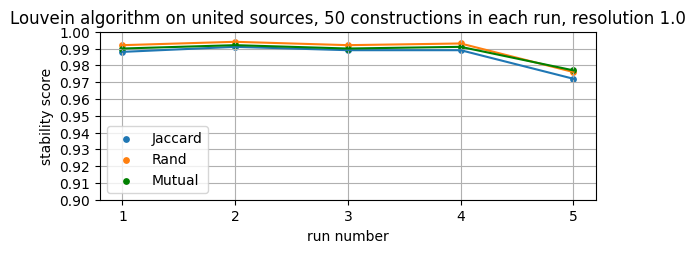

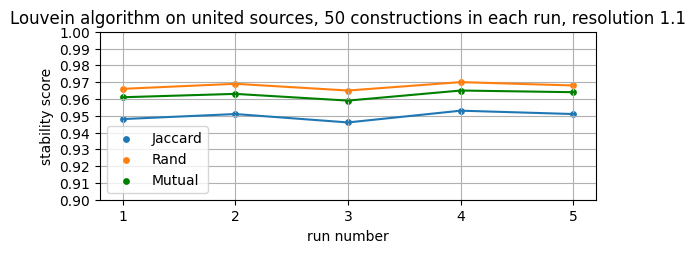

In [70]:
# Display results on ubited sources based on provenance data for both tested resolutions
# Separate plot for each resolution
# Figure 4.6

plt.subplot(2, 1, 1)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(community_variants_prov[0][x], provenance_dict) for x in range(5)], s=15, c='tab:blue', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(community_variants_prov[0][x], provenance_dict) for x in range(5)], c='tab:blue')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(community_variants_labels_prov[0][x]) for x in range(5)], s=15, c='tab:orange', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(community_variants_labels_prov[0][x]) for x in range(5)], c='tab:orange')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(community_variants_labels_prov[0][x]) for x in range(5)], s=15, c='g', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(community_variants_labels_prov[0][x]) for x in range(5)], c='g')

plt.title('Louvein algorithm on united sources, 50 constructions in each run, resolution 1.0')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("stability score")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()


plt.subplot(2, 1, 2)
plt.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(community_variants_prov[1][x], provenance_dict) for x in range(5)], s=15, c='tab:blue', marker="o", label="Jaccard")
plt.plot([1, 2, 3, 4, 5], [count_jaccard(community_variants_prov[1][x], provenance_dict) for x in range(5)], c='tab:blue')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(community_variants_labels_prov[1][x]) for x in range(5)], s=15, c='tab:orange', marker="o", label="Rand")
plt.plot([1, 2, 3, 4, 5], [count_rand(community_variants_labels_prov[1][x]) for x in range(5)], c='tab:orange')

plt.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(community_variants_labels_prov[1][x]) for x in range(5)], s=15, c='g', marker="o", label="Mutual")
plt.plot([1, 2, 3, 4, 5], [count_mutual(community_variants_labels_prov[1][x]) for x in range(5)], c='g')

plt.title('Louvein algorithm on united sources, 50 constructions in each run, resolution 1.1')
plt.xlabel("run number")
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel("stability score")
plt.yticks([0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
plt.grid()
plt.legend(loc='lower left')
plt.show()

### Compare some feasts between each other

Let's look at 10 biggest feasts (based on number of records)  
Find communities for sources that contains them all (51) for each feast separately  
and then compare them by our stability metrics
(check stability of more feasts)

In [13]:
# Get 10 feasts with most data
biggest_feasts = chants['feast_id'].value_counts()[:10].keys()

for feast_id in biggest_feasts.tolist():
    print(feasts[feasts['id'] == feast_id]['name'].values[0])

Nativitas Domini
Purificatio Mariae
Epiphania
Assumptio Mariae
Comm. Apostolorum
Comm. plurimorum Martyrum
Omnium Sanctorum
Fer. 5 in Cena Dom.
Dom. in Palmis
Joannis Baptistae


In [14]:
# Find those sources that contain data for all our biggests feasts
all_big_f_sources = []
for source_id in sources['drupal_path'].tolist():
    if len(set(biggest_feasts.tolist()).intersection(set(chants[chants['source_id'] == source_id]['feast_id'].tolist()))) == 10:
        all_big_f_sources.append(source_id)

print('Number of sources containing all our biggest feasts:', len(all_big_f_sources))

Number of sources containing all our biggest feasts: 51


In [15]:
# Dictionary for all_big_f_sources (used in Jaccard Index computation)
each_f_sources_dict = OrderedDict()
i = 0
for id in all_big_f_sources:
    each_f_sources_dict[id] = i
    i += 1

In [16]:
# Collect data of chants in sources for each big feast
big_feasts_source_chants_dict = {}

for feast_id in biggest_feasts.tolist():
    big_feasts_source_chants_dict[feast_id] = {}
    filt_feast = chants['feast_id'] == feast_id
    chants_of_feast = chants[filt_feast]
    for source_id in all_big_f_sources:
        filt_source = chants_of_feast['source_id'] == source_id
        if (chants_of_feast[filt_source]['cantus_id']).tolist() != []:
            big_feasts_source_chants_dict[feast_id][source_id] = (chants_of_feast[filt_source]['cantus_id']).tolist()
        else:
            print(source_id)

In [17]:
# Options for estimation of stability of each feast
each_f_res_opt = [0.9, 1.0, 1.1, 1.2]
random_states_each_f = [i for i in range(42, 1550)]

In [18]:
# Run 15 Louvein runs for each feast for different resoluitions to get stability of each feast
each_feast_dict = {}
for feast_id in biggest_feasts.tolist():
    graph = get_graph(all_big_f_sources, big_feasts_source_chants_dict[feast_id])
    each_feast_dict[feast_id] = {}
    each_feast_dict[feast_id]['vars'] = []
    each_feast_dict[feast_id]['labels'] = []
    each_feast_dict[feast_id]['clusters'] = []
    for r in range(len(each_f_res_opt)): 
        rndm_idx = 0
        each_feast_dict[feast_id]['vars'].append([])
        each_feast_dict[feast_id]['labels'].append([])
        each_feast_dict[feast_id]['clusters'].append([])
        for i in range(15):
            variant = nx.community.louvain_communities(graph, weight='weight', resolution=each_f_res_opt[r], seed=random_states_each_f[rndm_idx])
            each_feast_dict[feast_id]['vars'][r].append(variant)
            each_feast_dict[feast_id]['clusters'][r].append(len(variant))
            each_feast_dict[feast_id]['labels'][r].append(transform_to_labels(variant, each_f_sources_dict))
            rndm_idx+=1

In [107]:
for feast_id in biggest_feasts.tolist():
    print(feasts[feasts['id'] == feast_id]['name'].values[0])
    for r in range(len(each_f_res_opt)):
        print('  ', each_f_res_opt[r])
        print('     Jaccard:', count_jaccard(each_feast_dict[feast_id]['vars'][r], each_f_sources_dict), 
              '     Rand:', count_rand(each_feast_dict[feast_id]['labels'][r]), 
              '    Mutual:', count_mutual(each_feast_dict[feast_id]['labels'][r]))

Nativitas Domini
   0.9
     Jaccard: 1.0      Rand: 1.0     Mutual: 1.0
   1.0
     Jaccard: 1.0      Rand: 1.0     Mutual: 1.0
   1.1
     Jaccard: 0.963      Rand: 0.974     Mutual: 0.986
   1.2
     Jaccard: 1.0      Rand: 1.0     Mutual: 1.0
Purificatio Mariae
   0.9
     Jaccard: 1.0      Rand: 1.0     Mutual: 1.0
   1.0
     Jaccard: 0.848      Rand: 0.882     Mutual: 0.896
   1.1
     Jaccard: 0.938      Rand: 0.961     Mutual: 0.975
   1.2
     Jaccard: 0.979      Rand: 0.988     Mutual: 0.99
Epiphania
   0.9
     Jaccard: 1.0      Rand: 1.0     Mutual: 1.0
   1.0
     Jaccard: 0.606      Rand: 0.59     Mutual: 0.621
   1.1
     Jaccard: 0.779      Rand: 0.851     Mutual: 0.897
   1.2
     Jaccard: 0.928      Rand: 0.958     Mutual: 0.957
Assumptio Mariae
   0.9
     Jaccard: 0.705      Rand: 0.462     Mutual: 0.504
   1.0
     Jaccard: 0.733      Rand: 0.75     Mutual: 0.793
   1.1
     Jaccard: 0.953      Rand: 0.968     Mutual: 0.971
   1.2
     Jaccard: 0.963      Rand: 0.

In [23]:
# Average scores for each resolution
for r in range(len(each_f_res_opt)):
    print('resolution:', each_f_res_opt[r])
    jacc = []
    rand = []
    mut = []
    clust = []
    for feast_id in biggest_feasts.tolist():
        jacc.append(count_jaccard(each_feast_dict[feast_id]['vars'][r], each_f_sources_dict))
        rand.append(count_rand(each_feast_dict[feast_id]['labels'][r]))
        mut.append(count_mutual(each_feast_dict[feast_id]['labels'][r]))
        clust.append(each_feast_dict[feast_id]['clusters'][r])
    print('  Jaccard:', round(np.mean(jacc), 3), jacc)
    print('  Rand:', round(np.mean(rand), 3), rand)
    print('  Mutual:', round(np.mean(mut), 3), mut)
    print('  Clusters:', round(np.mean(clust), 3), [round(np.mean(x), 2) for x in clust])
    print()

resolution: 0.9
  Jaccard: 0.932 [1.0, 1.0, 1.0, 0.705, 1.0, 0.901, 0.722, 1.0, 0.99, 1.0]
  Rand: 0.894 [1.0, 1.0, 1.0, 0.462, 1.0, 0.892, 0.722, 1.0, 0.867, 1.0]
  Mutual: 0.897 [1.0, 1.0, 1.0, 0.504, 1.0, 0.857, 0.739, 1.0, 0.867, 1.0]
  Clusters: 1.447 [1.0, 1.0, 1.0, 2.6, 1.0, 2.0, 2.8, 1.0, 1.07, 1.0]

resolution: 1.0
  Jaccard: 0.819 [1.0, 0.848, 0.606, 0.733, 0.786, 0.792, 0.862, 0.702, 0.964, 0.895]
  Rand: 0.828 [1.0, 0.882, 0.59, 0.75, 0.813, 0.812, 0.88, 0.698, 0.97, 0.889]
  Mutual: 0.839 [1.0, 0.896, 0.621, 0.793, 0.801, 0.827, 0.874, 0.746, 0.966, 0.866]
  Clusters: 3.347 [3.0, 4.27, 3.07, 3.93, 3.67, 3.13, 3.0, 3.47, 3.0, 2.93]

resolution: 1.1
  Jaccard: 0.908 [0.963, 0.938, 0.779, 0.953, 0.86, 0.95, 0.908, 0.871, 0.863, 0.99]
  Rand: 0.936 [0.974, 0.961, 0.851, 0.968, 0.907, 0.968, 0.923, 0.918, 0.895, 0.995]
  Mutual: 0.946 [0.986, 0.975, 0.897, 0.971, 0.922, 0.976, 0.915, 0.932, 0.894, 0.994]
  Clusters: 7.593 [7.0, 6.87, 9.4, 5.07, 7.93, 6.0, 3.0, 13.27, 5.47, 11.9

In [25]:
# Check distribution of sources in communities for possible patology
for feast_id in biggest_feasts.tolist():
    print(feasts[feasts['id'] == feast_id]['name'].values[0])
    for r in range(len(each_f_res_opt)):
        print(each_f_res_opt[r])
        lens = []
        for com in each_feast_dict[feast_id]['vars'][r][0]:
            lens.append(len(com))
        print(lens)

Nativitas Domini
0.9
[51]
1.0
[13, 18, 20]
1.1
[10, 14, 5, 3, 3, 4, 12]
1.2
[10, 7, 3, 3, 4, 3, 1, 3, 2, 3, 5, 7]
Purificatio Mariae
0.9
[51]
1.0
[12, 7, 18, 14]
1.1
[8, 8, 6, 9, 7, 3, 10]
1.2
[1, 6, 6, 8, 2, 6, 3, 2, 2, 7, 8]
Epiphania
0.9
[51]
1.0
[16, 22, 13]
1.1
[1, 9, 7, 6, 6, 2, 7, 4, 6, 3]
1.2
[5, 6, 2, 1, 1, 4, 3, 1, 1, 1, 4, 2, 1, 1, 2, 3, 3, 3, 1, 3, 3]
Assumptio Mariae
0.9
[41, 8, 2]
1.0
[18, 16, 11, 6]
1.1
[7, 11, 13, 10, 10]
1.2
[2, 7, 2, 3, 10, 6, 3, 3, 4, 7, 4]
Comm. Apostolorum
0.9
[51]
1.0
[11, 21, 19]
1.1
[1, 2, 8, 7, 10, 2, 13, 8]
1.2
[7, 3, 1, 1, 2, 2, 7, 2, 2, 3, 1, 1, 8, 5, 6]
Comm. plurimorum Martyrum
0.9
[31, 20]
1.0
[19, 10, 22]
1.1
[9, 10, 10, 3, 13, 6]
1.2
[7, 10, 11, 8, 3, 2, 10]
Omnium Sanctorum
0.9
[27, 24]
1.0
[12, 17, 22]
1.1
[12, 20, 19]
1.2
[5, 12, 8, 7, 18, 1]
Fer. 5 in Cena Dom.
0.9
[51]
1.0
[12, 21, 15, 3]
1.1
[6, 9, 1, 3, 6, 5, 6, 3, 1, 1, 1, 2, 5, 2]
1.2
[1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 

From printed result above we decided to try 1.0, 1.1 and 1.2 resolution options
To make it comparable with previous results (50 matrices in 5 runs) we have to construct 5 variants for each feast, 5 times (runs)

In [17]:
each_f_final_res_opt = [1.0, 1.1, 1.2]

In [20]:
# have graphs ready so full run can be code in more readable way
each_f_garph_dict = {}
for feast_id in biggest_feasts.tolist():
    graph = get_graph(all_big_f_sources, big_feasts_source_chants_dict[feast_id])
    each_f_garph_dict[feast_id] = graph

In [21]:
# Five runs of 5 constructions for each feast (so sum is 50 as in experiments above)
each_f_final_dict = {}
rndm_idx = 0
for res in each_f_final_res_opt:
    each_f_final_dict[res] = []
    for i in range(5): # number of runs
        each_f_final_dict[res].append({'vars' : [], 'labels' : [], 'clusters' : []})
        for feast_id in biggest_feasts.tolist():
            for j in range(5): # number of varinats for each feast in each run
                variant = nx.community.louvain_communities(each_f_garph_dict[feast_id], weight='weight', resolution=res, seed=random_states_each_f[rndm_idx])
                each_f_final_dict[res][i]['vars'].append(variant)
                each_f_final_dict[res][i]['labels'].append(transform_to_labels(variant, each_f_sources_dict))
                each_f_final_dict[res][i]['clusters'].append(len(variant))
                rndm_idx += 1

In [19]:
# Stability of results
print('Average among 5 runs for each resolution \n')
for res in each_f_final_res_opt:
    print('resolution:', res)
    jacc = []
    rand = []
    mut = []
    clust = []
    for i in range(5):
        jacc.append(count_jaccard(each_f_final_dict[res][i]['vars'], each_f_sources_dict))
        rand.append(count_rand(each_f_final_dict[res][i]['labels']))
        mut.append(count_mutual(each_f_final_dict[res][i]['labels']))
        clust.append(each_f_final_dict[res][i]['clusters'])
    print('  Jaccard:', round(np.mean(jacc), 3), jacc)
    print('  Rand:', round(np.mean(rand), 3), rand)
    print('  Mutual:', round(np.mean(mut), 3), mut)
    print('  Clusters:', round(np.mean(clust), 3))
    print()

Average among 5 runs for each resolution 

resolution: 1.0
  Jaccard: 0.359 [0.365, 0.356, 0.362, 0.354, 0.356]
  Rand: 0.26 [0.269, 0.25, 0.276, 0.249, 0.256]
  Mutual: 0.288 [0.298, 0.277, 0.303, 0.277, 0.285]
  Clusters: 3.324

resolution: 1.1
  Jaccard: 0.281 [0.283, 0.28, 0.279, 0.283, 0.28]
  Rand: 0.306 [0.307, 0.304, 0.304, 0.308, 0.307]
  Mutual: 0.389 [0.39, 0.388, 0.387, 0.391, 0.39]
  Clusters: 7.632

resolution: 1.2
  Jaccard: 0.256 [0.257, 0.256, 0.255, 0.257, 0.255]
  Rand: 0.315 [0.316, 0.315, 0.315, 0.315, 0.314]
  Mutual: 0.392 [0.392, 0.392, 0.391, 0.392, 0.391]
  Clusters: 15.172



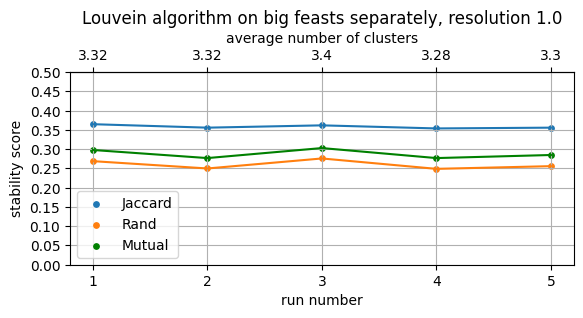

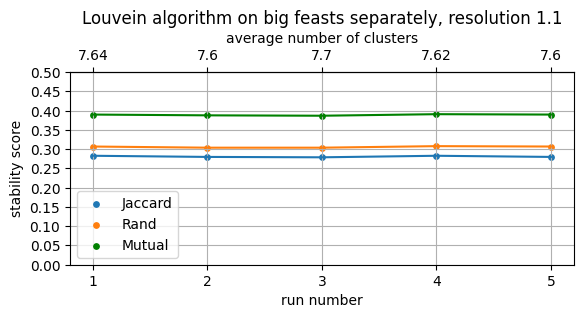

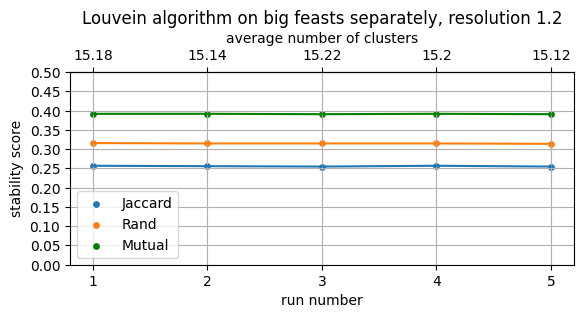

In [27]:
# Plot stability of results
# Figure 4.16
for res in each_f_final_res_opt:
    fig = plt.figure(figsize=(6.5,2.5))
    ax1 = fig.add_subplot(111)
    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_jaccard(each_f_final_dict[res][x]['vars'], each_f_sources_dict) for x in range(5)], s=15, c='tab:blue', marker="o", label="Jaccard")
    ax1.plot([1, 2, 3, 4, 5], [count_jaccard(each_f_final_dict[res][x]['vars'], each_f_sources_dict) for x in range(5)], c='tab:blue')

    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_rand(each_f_final_dict[res][x]['labels']) for x in range(5)], s=15, c='tab:orange', marker="o", label="Rand")
    ax1.plot([1, 2, 3, 4, 5], [count_rand(each_f_final_dict[res][x]['labels']) for x in range(5)], c='tab:orange')

    ax1.scatter(x=[1, 2, 3, 4, 5], y=[count_mutual(each_f_final_dict[res][x]['labels']) for x in range(5)], s=15, c='g', marker="o", label="Mutual")
    ax1.plot([1, 2, 3, 4, 5], [count_mutual(each_f_final_dict[res][x]['labels']) for x in range(5)], c='g')

    ax2 = ax1.secondary_xaxis('top')
    avg_clusters = [round(np.mean(each_f_final_dict[res][i]['clusters']), 2) for i in range(5) ]
    ax2.set_xlabel("average number of clusters")
    ax2.set_xticks([1, 2, 3, 4, 5])
    ax2.set_xticklabels(avg_clusters)

    plt.title('Louvein algorithm on big feasts separately, resolution ' + str(res))
    plt.xlabel("run number")
    plt.xticks([1, 2, 3, 4, 5])
    plt.ylabel("stability score")
    plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

#### Stability of each feast - more feasts


In [141]:
# Select "more serious" feasts - having more than 24 records of antiphons or responsories
freq_of_feasts = chants['feast_id'].value_counts()
feasts_without_little = freq_of_feasts.drop(freq_of_feasts[freq_of_feasts.values < 25].index).index.tolist()
print(len(feasts_without_little))

737


In [142]:
jacc_by_feasts = {1.0 : [], 1.1 : [], 1.2 : []}
rand_by_feasts = {1.0 : [], 1.1 : [], 1.2 : []}
mutual_by_feasts = {1.0 : [], 1.1 : [], 1.2 : []}
num_of_clusts_by_feasts = {1.0 : [], 1.1 : [], 1.2 : []}

random_states_by_feasts = [i for i in range(42, 50000)]
rndm_idx = 0
for feast_id in feasts_without_little:
    used_sources = []
    source_chants_dict = {}
    filt_feast = chants['feast_id'] == feast_id
    chants_of_feast = chants[filt_feast]
    for source_id in sources['drupal_path']:
        filt_source = chants_of_feast['source_id'] == source_id
        if (chants_of_feast[filt_source]['cantus_id']).tolist() != []:
            used_sources.append(source_id)
            source_chants_dict[source_id] = (chants_of_feast[filt_source]['cantus_id']).tolist()

    graph = get_graph(used_sources, source_chants_dict)

    source_f_dict = OrderedDict()
    i = 0
    for id in used_sources:
        source_f_dict[id] = i
        i += 1

    for res in [1.0, 1.1, 1.2]:
        vars = []
        labels = []
        clusters = []
        for _ in range(10):
            variant = nx.community.louvain_communities(graph, weight='weight', resolution=res, seed=random_states_by_feasts[rndm_idx])
            vars.append(variant)
            labels.append(transform_to_labels(variant, source_f_dict))
            clusters.append(len(variant))
            rndm_idx += 1
        jacc_by_feasts[res].append(count_jaccard(vars, source_f_dict))
        rand_by_feasts[res].append(count_rand(labels))
        mutual_by_feasts[res].append(count_mutual(labels))
        num_of_clusts_by_feasts[res].append(round(np.mean(clusters), 2))


In [140]:
# Look at some basic statistics
from scipy import stats
print('Basic statistic on 737 feasts, stability computed for each, 10 constructions of each')
for res in [1.0, 1.1, 1.2]:
    print('--------------------')
    print('resolution:', res)
    print('  mean of jaccard among feasts:', np.mean(jacc_by_feasts[res]))
    print('  median of jaccard among feasts:', np.median(jacc_by_feasts[res]))
    print('  mode of jaccard among feasts', stats.mode(jacc_by_feasts[res]).mode, 'with count', stats.mode(jacc_by_feasts[res]).count)
    unique, counts = np.unique(jacc_by_feasts[res], return_counts=True)
    jacc_less = 0
    for score in dict(zip(unique, counts)).keys():
        if score < 0.9:
            jacc_less += dict(zip(unique, counts))[score]
    print('  number of feasts with jaccard score < 0.9:', jacc_less)
    print()
    print('  mean of rand among feasts:', np.mean(rand_by_feasts[res]))
    print('  median of rand among feasts:', np.median(rand_by_feasts[res]))
    print('  mode of rand among feasts:', stats.mode(rand_by_feasts[res]).mode, 'with count:', stats.mode(rand_by_feasts[res]).count)
    unique, counts = np.unique(rand_by_feasts[res], return_counts=True)
    rand_less = 0
    for score in dict(zip(unique, counts)).keys():
        if score < 0.9:
            rand_less += dict(zip(unique, counts))[score]
    print('  number of feasts with rand score < 0.9:', rand_less)
    print()
    print('  mean of mutual among feasts:', np.mean(mutual_by_feasts[res]))
    print('  median of mutual among feasts:', np.median(mutual_by_feasts[res]))
    print('  mode of mutual among feasts:', stats.mode(mutual_by_feasts[res]).mode, 'with count:', stats.mode(mutual_by_feasts[res]).count)
    unique, counts = np.unique(mutual_by_feasts[res], return_counts=True)
    mut_less = 0
    for score in dict(zip(unique, counts)).keys():
        if score < 0.9:
            mut_less += dict(zip(unique, counts))[score]
    print('  number of feasts with mutual score < 0.9', mut_less)
    print()
    print('  average number of communitues found', round(np.mean(num_of_clusts_by_feasts[res]), 2))
    print()
    

Basic statistic on 737 feasts, stability computed for each, 5 constructions of each
--------------------
resolution: 1.0
  mean of jaccard among feasts: 0.8666947082767978
  median of jaccard among feasts: 1.0
  mode of jaccard among feasts 1.0 with count 483
  number of feasts with jaccard score < 0.9: 181

  mean of rand among feasts: 0.9675793758480326
  median of rand among feasts: 1.0
  mode of rand among feasts: 1.0 with count: 554
  number of feasts with rand score < 0.9: 96

  mean of mutual among feasts: 0.9546309362279511
  median of mutual among feasts: 1.0
  mode of mutual among feasts: 1.0 with count: 542
  number of feasts with mutual score < 0.9 103

  average number of communitues found 3.83

--------------------
resolution: 1.1
  mean of jaccard among feasts: 0.8592198100407055
  median of jaccard among feasts: 1.0
  mode of jaccard among feasts 1.0 with count 437
  number of feasts with jaccard score < 0.9: 200

  mean of rand among feasts: 0.9668507462686566
  median